# Vehicle detection

In [12]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

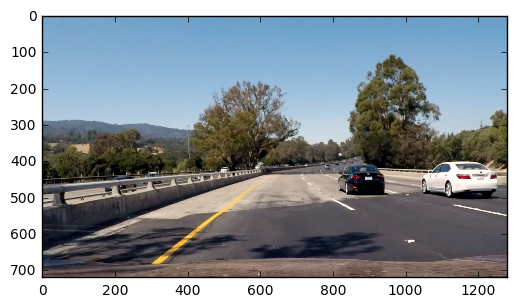

In [13]:
list_images = glob.glob('test_images/*')
img_test = cv2.imread(list_images[0])
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_test)

In [44]:
# functions to use in main code

''' from udacity lessons '''
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


def get_data(vehicle_path, non_vehicle_path):
    x_data = None
    y_data = None
    im_v = glob.glob(vehicle_path + '/*')
    for each_path in im_v:
        im_list = glob.glob(each_path + '/*')
        print(im_list)
    return x_data, y_data

In [45]:
my_x, my_y = get_data('vehicles/vehicles', 'non-vehicles/non-vehicles')

['vehicles/vehicles/GTI_Right/image0578.png', 'vehicles/vehicles/GTI_Right/image0819.png', 'vehicles/vehicles/GTI_Right/image0972.png', 'vehicles/vehicles/GTI_Right/image0952.png', 'vehicles/vehicles/GTI_Right/image0585.png', 'vehicles/vehicles/GTI_Right/image0189.png', 'vehicles/vehicles/GTI_Right/image0866.png', 'vehicles/vehicles/GTI_Right/image0498.png', 'vehicles/vehicles/GTI_Right/image0182.png', 'vehicles/vehicles/GTI_Right/image0912.png', 'vehicles/vehicles/GTI_Right/image0191.png', 'vehicles/vehicles/GTI_Right/image0720.png', 'vehicles/vehicles/GTI_Right/image0325.png', 'vehicles/vehicles/GTI_Right/image0506.png', 'vehicles/vehicles/GTI_Right/image0932.png', 'vehicles/vehicles/GTI_Right/image0576.png', 'vehicles/vehicles/GTI_Right/image0592.png', 'vehicles/vehicles/GTI_Right/image0332.png', 'vehicles/vehicles/GTI_Right/image0726.png', 'vehicles/vehicles/GTI_Right/image0620.png', 'vehicles/vehicles/GTI_Right/image0615.png', 'vehicles/vehicles/GTI_Right/image0188.png', 'vehicles